## **Jupyter Notebook** for the article [A gentle introduction to Automatic Differentiation | by Pablo Monteagudo | Medium](https://medium.com/@pablo.monteagudo.lago/a-gentle-introduction-to-automatic-differentiation-74e7eb9a75af).

In [ ]:
# Import math Library
import math
from typing import List, NamedTuple, Callable, Dict, Optional

_name: int = 1
_verbose: bool = False

def print_verbose(string : str):
  global _verbose
  if _verbose:
    print(string)

def fresh_name() -> str:
    """ create a new unique name for a variable: v0, v1, v2 """
    global _name
    r = f'v{_name}'
    _name += 1
    return r

In [ ]:
class Variable:
    def __init__(self, value : float, name: str=None):
        self.value = value
        self.name = name or fresh_name()

    # This function allows us to create the leaf nodes
    @staticmethod
    def constant(value: float, name: str=None):
        r = Variable(value, name)
        print_verbose(f'{r.name} = {value:.3f}')
        return r

    def __repr__(self):
        return repr(self.value)

    def __mul__(self, rhs: 'Variable') -> 'Variable':
        return operator_mul(self, rhs)

    def __add__(self, rhs: 'Variable') -> 'Variable':
        return operator_add(self, rhs)

    def __sub__(self, rhs: 'Variable') -> 'Variable':
        return operator_add(self, -rhs)

    def __truediv__(self, rhs: 'Variable') -> 'Variable':
        return operator_mul(self, inv(rhs))

    def __neg__(self) -> 'Variable':
        return operator_neg(self)

In [ ]:
class TapeEntry(NamedTuple):
    # names of the inputs to the original computation
    inputs : List[str]
    # names of the outputs of the original computation
    outputs: List[str]
    # apply chain rule
    propagate: 'Callable[List[Variable], List[Variable]]'

In [ ]:
gradient_tape : List[TapeEntry] = []

def reset_tape():
  gradient_tape.clear()
  global _name
  _name = 1 # reset variable names too to keep them small.


In [ ]:
def operator_mul(self : Variable, rhs: Variable) -> Variable:
    # define forward
    r = Variable(self.value * rhs.value)
    print_verbose(f'{r.name} = {self.name} * {rhs.name} = {r.value:.3f}')

    # record what the inputs and outputs of the op were
    inputs = [self.name, rhs.name]
    outputs = [r.name]

    # define backprop
    def propagate(dL_doutputs: List[Variable]):
        dL_dr, = dL_doutputs 
        # partial derivative of r = self*rhs
        dr_dself = rhs
        # partial derivative of r = self*rhs
        dr_drhs = self
        # chain rule propagation from outputs to inputs of multiply
        dL_dself = dL_dr * dr_dself
        dL_drhs = dL_dr * dr_drhs
        dL_dinputs = [dL_dself, dL_drhs] 
        return dL_dinputs
    # finally, we record the compute we did on the tape
    gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
    return r

def operator_add(self : Variable, rhs: Variable) -> Variable:
  #define forward
  r = Variable(self.value + rhs.value)
  print_verbose(f'{r.name} = {self.name} + {rhs.name} = {r.value:.3f}')

  # record what the inputs and outputs of the op were
  inputs = [self.name, rhs.name]
  outputs = [r.name]

  # define backprop
  def propagate(dL_doutputs: List[Variable]):
        dL_dr, = dL_doutputs
        # partial derivative of r = self+rhs
        #dr_dself = 1.0
        # partial derivative of r = self+rhs
        #dr_drhs = 1.0
        # chain rule propagation from outputs to inputs of add
        dL_dself = dL_dr
        dL_drhs = dL_dr
        return [dL_dself, dL_drhs]
  # finally, we record the compute we did on the tape
  gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
  return r

def operator_neg(self : Variable) -> Variable:
  #define forward
  r = Variable(-self.value)
  print_verbose(f'{r.name} = -{self.name} = {r.value:.3f}')

  # record what the inputs and outputs of the op were
  inputs = [self.name]
  outputs = [r.name]

  # define backprop
  def propagate(dL_doutputs: List[Variable]):
        dL_dr, = dL_doutputs
        # partial derivative of r = - self
        #dr_dself = - 1.0
        # chain rule propagation from outputs to inputs of neg
        dL_dself = - dL_dr
        return [dL_dself]
  # finally, we record the compute we did on the tape
  gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
  return r

def inv(rhs: Variable) -> Variable:
    #define forward
    r = Variable(1.0 / rhs.value)
    print_verbose(f'{r.name} = 1.0 / {rhs.name} = {r.value:.3f}')

    # record what the inputs and outputs of the op were
    inputs = [rhs.name]
    outputs = [r.name]

    # define backprop
    def propagate(dL_doutputs: List[Variable]):
          dL_dr, = dL_doutputs
          # partial derivative of r = 1.0 / rhs
          dr_drhs = - inv(rhs * rhs)
          # chain rule propagation from outputs to inputs of inv
          dL_drhs = dL_dr * dr_drhs
          return [dL_drhs]
    # finally, we record the compute we did on the tape
    gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
    return r

def ln(rhs: Variable) -> Variable:
    #define forward
    r = Variable(math.log(rhs.value))
    print_verbose(f'{r.name} = log({rhs.name}) = {r.value:.3f}')

    # record what the inputs and outputs of the op were
    inputs = [rhs.name]
    outputs = [r.name]

    # define backprop
    def propagate(dL_doutputs: List[Variable]):
          dL_dr, = dL_doutputs
          # partial derivative of r = ln(rhs)
          dr_drhs = inv(rhs)
          # chain rule propagation from outputs to inputs of ln
          dL_drhs = dL_dr * dr_drhs
          return [dL_drhs]
    # finally, we record the compute we did on the tape
    gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
    return r

def sin(rhs: Variable) -> Variable:
    #define forward
    r = Variable(math.sin(rhs.value))
    print_verbose(f'{r.name} = sin({rhs.name}) = {r.value:.3f}')

    # record what the inputs and outputs of the op were
    inputs = [rhs.name]
    outputs = [r.name]

    # define backprop
    def propagate(dL_doutputs: List[Variable]):
          dL_dr, = dL_doutputs
          # partial derivative of r = sin(rhs)
          dr_drhs = cos(rhs)
          # chain rule propagation from outputs to inputs of cos
          dL_drhs = dL_dr * dr_drhs
          return [dL_drhs]
    # finally, we record the compute we did on the tape
    gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
    return r

def cos(rhs: Variable) -> Variable:
    #define forward
    r = Variable(math.cos(rhs.value))
    print_verbose(f'{r.name} = cos({rhs.name}) = {r.value:.3f}')

    # record what the inputs and outputs of the op were
    inputs = [rhs.name]
    outputs = [r.name]

    # define backprop
    def propagate(dL_doutputs: List[Variable]):
          dL_dr, = dL_doutputs
          # partial derivative of r = cos(rhs)
          dr_drhs = - sin(rhs)
          # chain rule propagation from outputs to inputs of sin
          dL_drhs = dL_dr * dr_drhs
          return [dL_drhs]
    # finally, we record the compute we did on the tape
    gradient_tape.append(TapeEntry(inputs=inputs, outputs=outputs, propagate=propagate))
    return r

In [ ]:
def grad(L, desired_results: List[Variable]) -> List[Variable]:
    # this map holds the adjoints for each variables
    dL_d : Dict[str, Variable] = {}
    # the adjoint for the output variable is 1.0
    dL_d[L.name] = Variable(1.0)
    print_verbose(f'd{L.name} ------------------------')

    # If a variable is never used to compute the loss, we consider its gradient None
    def gather_grad(entries: List[str]):
        return [dL_d[entry] if entry in dL_d else None for entry in entries]

    # propagate the gradient information backward
    for entry in reversed(gradient_tape):
        dL_doutputs = gather_grad(entry.outputs)
        if all(dL_doutput is None for dL_doutput in dL_doutputs):
            # optimize for the case where some gradient pathways are zero. See
            # The note below for more details.
            continue

        # perform chain rule propagation specific to each compute
        dL_dinputs = entry.propagate(dL_doutputs)

        # Accumulate the gradient produced for each input,
        #by adding up the contributions along each path
        for input, dL_dinput in zip(entry.inputs, dL_dinputs):
            if input not in dL_d:
                dL_d[input] = dL_dinput
            else:
                dL_d[input] += dL_dinput

    for name, value in dL_d.items():
        print_verbose(f'd{L.name}_d{name} = {value.name}')
    print_verbose(f'------------------------')

    #in case a variable was not used to compute the function, we return None
    return gather_grad(desired.name for desired in desired_results)

In [ ]:
reset_tape() # reset any compute from other cells
_verbose = True

def f(x1: Variable, x2: Variable) -> Variable:
  return ln(x1) + x1*sin(x2)

x1 = Variable.constant(2, name= 'v-1')
x2 = Variable.constant(1, name= 'v0')

result = f(x1, x2)

v-1 = 2.000
v0 = 1.000
v1 = log(v-1) = 0.693
v2 = sin(v0) = 0.841
v3 = v-1 * v2 = 1.683
v4 = v1 + v3 = 2.376


In [ ]:
dx1, dx2 = grad(result, [x1, x2])
print("dx1", dx1)
print("dx2", dx2)

dv4 ------------------------
v6 = v5 * v2 = 0.841
v7 = v5 * v-1 = 2.000
v8 = cos(v0) = 0.540
v9 = v7 * v8 = 1.081
v10 = 1.0 / v-1 = 0.500
v11 = v5 * v10 = 0.500
v12 = v6 + v11 = 1.341
dv4_dv4 = v5
dv4_dv1 = v5
dv4_dv3 = v5
dv4_dv-1 = v12
dv4_dv2 = v7
dv4_dv0 = v9
------------------------
dx1 1.3414709848078965
dx2 1.0806046117362795


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

input_size = 50
X = np.random.random(input_size)
noise = np.random.normal(0, 0.05, input_size)
y_truth = X + 1 + noise

X_expand = np.expand_dims(X, axis=1)
X_expand = np.insert(X_expand, 1, np.ones(input_size), axis=1)

In [ ]:
def backward(loss, weights, lr):
  #compute gradient for loss
  gradients = grad(loss, weights)
  #function to take a step in the direction of the gradient
  gradient_step = np.vectorize(lambda weight, gradient: Variable(weight.value - lr*gradient.value))
  #every iteration we will reset the gradient computations
  reset_tape()
  #return updated weights
  return gradient_step(weights, gradients)

#disable showing intermediate variables
_verbose = False
#reset any compute from other cells
reset_tape() 

#convert NumPy array into array of Variable objects
to_var = np.vectorize(lambda x : Variable(x))

#get values from array of Variable objects
to_vals = np.vectorize(lambda x : x.value)

#learning rate for gradient descent
lrate = 0.5
#number of gradient updates
num_iters = 50

#initialization of the weights for our model
weights = np.random.normal(0, 1, 2)

#we will save the loss and weights for latter visualization
loss_vals = []
weights_vals = []

#convert weights to variables
weights_var = to_var(weights)
for i in range(num_iters):
  #load sample data
  X_var = to_var(X_expand)
  y_truth_var = to_var(y_truth)

  #compute the predictions of the model and its loss
  y_var_pred = np.matmul(X_var, weights_var)
  loss = Variable.constant(1.0 / (2 * input_size))*np.sum((y_var_pred - y_truth_var) * (y_var_pred - y_truth_var))
  #update weights using gradient descent
  weights_var = backward(loss, weights_var, lrate)

  #save values for visualizations
  loss_vals.append(loss.value)
  weights_vals.append(to_vals(weights_var))

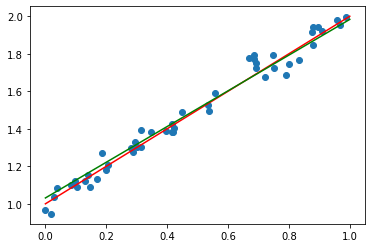

In [ ]:
weights = to_vals(weights_var)

plt.scatter(X, y_truth)
plt.plot([0, 1], [1, 2], 'k-', color = 'r')
plt.plot([0, 1], [weights[1], weights[0] + weights[1]], 'r', color='green')

plt.show()

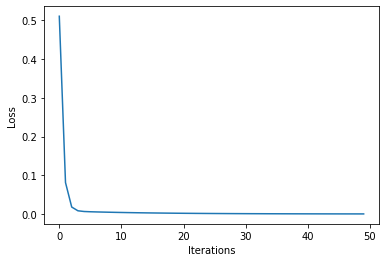

In [ ]:
plt.plot(loss_vals)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()